# Noisy Networks for Exploration
The key argument here is that "Noise drives exploration in many methods for reinforcement learning, providing a source of stochasticity external to the agent and the RL task at hand" (#TODO). 

Insofar, we have been using the epsilon-greedy exploration strategy to introduce randomness (and thus exploration) on the action space. We replace that by introducing stochasticity in the layers themselves!

Remember how linear layers work:
$$
y=wx\cdot b
$$
We will now use:
$$
y\overset{\text{def}}{=}(\mu^w+\sigma^w\odot\epsilon^w)x+\mu^b+\sigma^b\odot\epsilon^b
$$
Where $\mu$ and $\sigma$ are learnable parameters; $\epsilon$ is random noise introduced on every step.

Also, note how they decided to model this around the linear function. I'm pretty curious as to why! Probably something to do with why we also do so for the layer's output, which I don't actually remember, but I'm just making a guess here.

- paper: [Noisy Networks for Exploration](https://arxiv.org/abs/1706.10295)

## Initialization, imports

In [57]:
NB_ID = '05'

import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import random
import matplotlib.pyplot as plt

from IPython.display import clear_output

from typing import Dict, List, Tuple

plt.ion()

## Replay buffer

In [58]:

class ReplayBuffer:
    # obs_size = state/observable space size
    def __init__(self, max_size: int, obs_size: int, batch_size:int=32):
        self.state_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        self.action_buf = np.zeros(max_size, dtype=np.float32)
        self.reward_buf = np.zeros(max_size, dtype=np.float32)
        self.ns_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        self.done_buf = np.zeros(max_size, dtype=np.float32)

        self.max_size, self.batch_size = max_size, batch_size
        self.ptr, self.size = 0, 0

    def push(self, 
        state: np.ndarray, 
        action: int, 
        reward: float, 
        ns: np.ndarray, 
        done: bool,
    ):
        idx = self.ptr
        self.state_buf[idx] = state
        self.action_buf[idx] = action
        self.reward_buf[idx] = reward
        self.ns_buf[idx] = ns
        self.done_buf[idx] = done
        
        self.ptr = (idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def sample(self) -> Dict[str, np.ndarray]:
        idx = random.sample(range(self.size), self.batch_size)
        return dict(
            state=self.state_buf[idx],
            action=self.action_buf[idx],
            reward=self.reward_buf[idx],
            ns=self.ns_buf[idx],
            done=self.done_buf[idx],
        )

    def __len__(self):
        return self.size

## NoisyNet

In [59]:
class NoisyLinear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        std_init: float = 0.5
    ):
        super().__init__()
      
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        # https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723/2
        # register something on state_dict but DON'T make it a learnable parameter
        self.register_buffer(
            'weight_epsilon', torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer(
            'bias_epsilon', torch.Tensor(out_features)
        )

        # initialize parameters & noise
        with torch.no_grad():
            self.reset_parameters()
            self.reset_noise()

    def reset_parameters(self):
        """Initialize/reset learnable parameters"""
        
        '''
        NOTE: by default, nn.Linear initializes both weights and parameters
        from a uniform distribution bounded by [-sqrt(in_features), sqrt(in_features)]
        more on https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        NOTE: this is different from the original tutorial because I used
        `torch.no_grad()` rather than `Tensor.data.(...)`
        more on https://discuss.pytorch.org/t/which-copy-is-better/56393/2
        '''
        # mu - noise "bias"
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        # sigma - noise weight 
        # TODO: experiment with uniform distribution of sigma too
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
            x = torch.randn(size)
            # x = sgn(x) * sqrt(|x|)
            return x.sign().mul(x.abs().sqrt())

## Network (NoisyNet)

In [60]:
class Network(nn.Module):
    def __init__(self, obs_size: int, action_size: int):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, action_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

    def reset_noise(self):
        self.layers[2].reset_noise()
        self.layers[4].reset_noise()

## DQN agent

In [61]:
class DQNAgent:
    def __init__(self,
        env: gym.Env,
        seed: int,
        memory_size: int,
        batch_size: int,
        target_update: int,
        gamma: float = .99,
    ):
        self.env = env
        self.seed = seed
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        obs_size = env.observation_space.shape[0]
        # different from obs_size, we use Discrete, not Box -> https://www.gymlibrary.dev/api/spaces/#discrete
        action_size = env.action_space.n

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        self.memory = ReplayBuffer(10000, obs_size, batch_size)
        
        self.dqn = Network(obs_size, action_size).to(self.device)
        self.dqn_target = Network(obs_size, action_size).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)

        self.transition = []

        self.is_test = False

    def choose_action(self, state: np.ndarray) -> int:
        selected_action = self.dqn(torch.FloatTensor(state)).argmax().item()
        if not self.is_test:
            self.transition = [state, selected_action]
        return selected_action
    
    def take_step(self, action: int) -> Tuple[np.ndarray, np.float64, bool]:
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.push(*self.transition)
            
        return next_state, reward, done
    
    def compute_dqn(self, samples: dict[str, np.array]):
        device = self.device
        state = torch.FloatTensor(samples["state"], device=device)
        ns = torch.FloatTensor(samples["ns"], device=device)
        action = torch.LongTensor(samples["action"], device=device)
        reward = torch.FloatTensor(samples["reward"], device=device)
        done = torch.FloatTensor(samples["done"], device=device)

        curr_q_value = self.dqn(state).gather(1, action.unsqueeze(1))
        with torch.no_grad():
            next_q_value = self.dqn_target(ns).max(1)[0]
        mask = 1 - done
        target = (reward + next_q_value * self.gamma * mask).to(self.device)
        loss = F.smooth_l1_loss(curr_q_value.squeeze(), target)

        # # for debugging!
        # print('state', state[:2])
        # print('ns', ns[:2])
        # print('act', action[:2])
        # print('rew', reward[:2])
        # print('done', done[:2])
        # print('curr_q', curr_q_value[:2])
        # print('next_q', next_q_value[:2])
        # print('target', target[:2])

        return loss, torch.mean(curr_q_value).detach().numpy()
        
    def update_model(self) -> float:
        samples = self.memory.sample()

        loss, q_value = self.compute_dqn(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item(), q_value

    def train(self, seed: int, num_frames: int, plotting_interval: int=200):
        try:
            self.is_test = False

            state, _ = self.env.reset(seed=seed)
            # effective episode - n. of episodes after initial "memory gathering"
            total_episodes = 0
            eff_episode = 0
            score = 0
            scores = []
            losses = []
            predictions = []
            
            for frame_idx in range(1, num_frames+1):
                action = self.choose_action(state)
                next_state, reward, done = self.take_step(action)

                state = next_state
                score += reward

                if done:
                    total_episodes += 1
                    state, _ = self.env.reset(seed=seed+total_episodes)
                    scores.append(score)
                    score = 0
                if len(self.memory) >= self.batch_size:
                    loss, curr_q_value = self.update_model()
                    losses.append(loss)
                    predictions.append(curr_q_value)
                    eff_episode += 1

                    if eff_episode % self.target_update == 0:
                        self.target_hard_update()

                if frame_idx % plotting_interval == 0:
                    self._plot(frame_idx, scores, losses, predictions)
        except KeyboardInterrupt:
            self.save_state()
        else:
            self.save_state('saved-state-done')
        finally:
            self.env.close()
    
    def save_state(self, name='saved-state'):
        state_dict = self.dqn.state_dict()
        torch.save(state_dict, f'saved-states/{NB_ID}.s{self.seed}.pt')
        print('saved state!')
        return state_dict

    def load_state(self, state_dict):
        self.dqn.load_state_dict(state_dict)
        return state_dict
        
    def test(self, video_folder: str):
        self.is_test = True
        naive_env = self.env
        
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder, name_prefix=NB_ID)
        state, _ = self.env.reset()
        self.env.start_video_recorder()
        done = False
        score = 0
        while not done:
            action = self.choose_action(state)
            next_state, reward, done = self.take_step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = naive_env

    def target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(self, frame_idx, scores, losses, predictions):

        clear_output(wait=True)

        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), num=1, clear=True)

        ax1.set_title(f'frame {frame_idx} | avg. t-10 score: {np.mean(scores[-10:])}')
        ax1.plot(scores)
        ax1.set_xlabel('episode')
        ax1.set_ylabel('score')

        ax2.set_title('loss')
        ax2.plot(losses)

        ax3.set_title('Q value')
        ax3.plot(predictions)

        plt.show()

## Initializing nvironment

In [62]:
env_id = "CartPole-v1"
env = gym.make(env_id)

## Seeding

In [63]:
seed = 111

def seed_torch(seed):
    torch.manual_seed(seed)
    # https://pytorch.org/docs/stable/notes/randomness.html#cuda-convolution-benchmarking
    if torch.backends.cudnn.enabled:
        # this will make our model run the same across multiple executions,
        # at the cost of performance
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initializing agent

In [64]:
num_frames = 30_000
memory_size = 1_000
batch_size = 32
target_update = 100
epsilon_decay = 1/2000

agent = DQNAgent(env, seed, memory_size, batch_size, target_update)

## Training

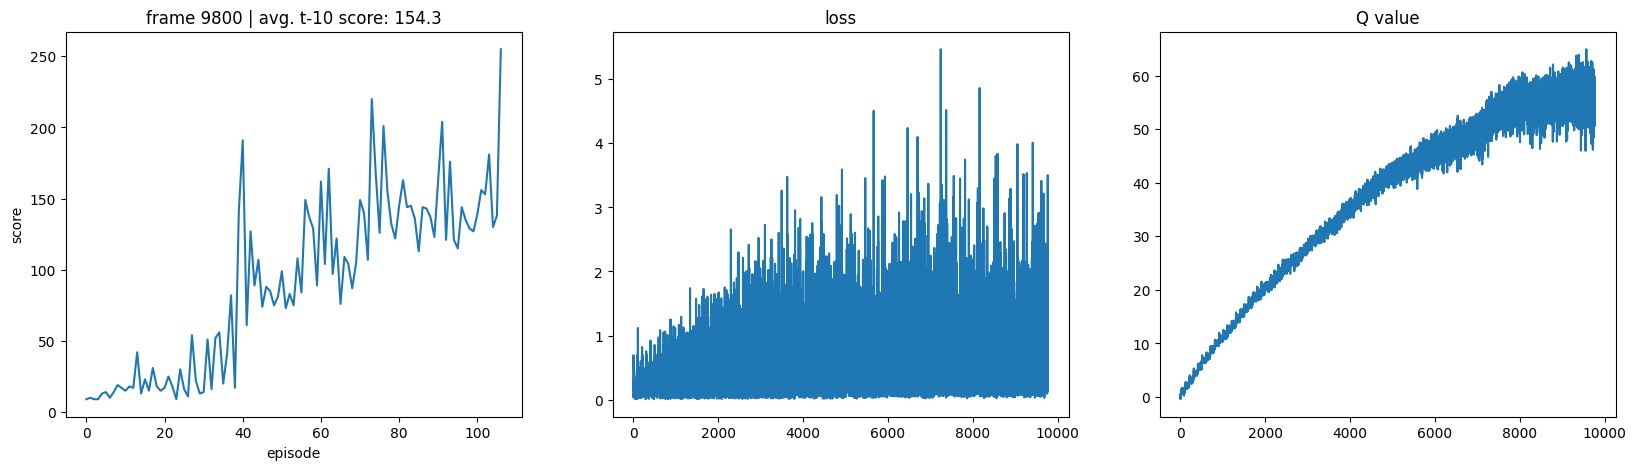

In [65]:
agent.train(seed, num_frames)

## Testing

In [ ]:
video_folder = 'videos'
env_w_video = gym.make(env_id, render_mode="rgb_array")
# NOTE: epsilon is disabled while testing
agent = DQNAgent(env_w_video, seed, memory_size, batch_size, target_update, epsilon_decay)
saved_sd = torch.load(f'saved-state/{NB_ID}.s{seed}.pt') 
agent.load_state(saved_sd)
agent.test(video_folder)